In [1]:
from __future__ import print_function
from __future__ import absolute_import

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

import numpy as np

In [5]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

Pysaliency
==========

Saliency Map Models
----------------------

`pysaliency` comes with a variety of features to evaluate saliency map models. This notebooks demonstrates these features.

First we load the MIT1003 dataset:

In [6]:
import sys
import pysaliency
from pysaliency.external_datasets.sjtuvis import TextDescriptor

data_location = 'test_datasets'
data_location = "../../datasets"
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_mit1003(location=data_location)

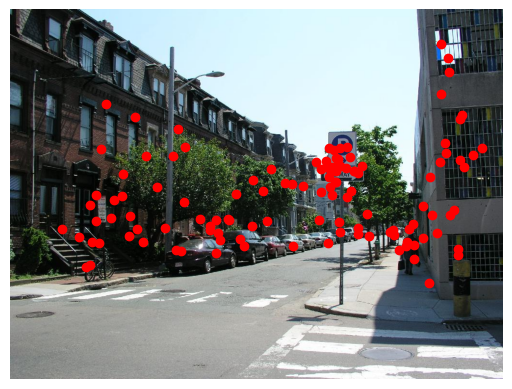

In [7]:
index = 0
plt.imshow(mit_stimuli.stimuli[index])
f = mit_fixations[mit_fixations.n == index]
plt.scatter(f.x, f.y, color='r')
_ = plt.axis('off')

As some evaluation methods can take quite a long time to run, we prepare a smaller dataset consisting of only the first 10 stimuli:

In [8]:
cutoff = 10
short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
short_fixations = mit_fixations[mit_fixations.n < cutoff]

My saliency map model.

In [9]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np




class MySaliencyMapModel(pysaliency.SaliencyMapModel):
    
    def _saliency_map(self, stimulus, text_description="People are walking into the houses with cars parking along the street."):
        # plt.show(stimulus)
        return self.evaluate_saliency_map(stimulus[...,:3], "large", text_description)
    
    def evaluate_saliency_map(self, raw_image, model_path, caption, block_num=7, dst_w=720):
        # Setup device to use
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Load model and preprocessors
        model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", model_path, device=device, is_eval=True)
        print(raw_image.shape, raw_image.dtype, np.max(raw_image), np.min(raw_image))
        raw_image = Image.fromarray(np.uint8(raw_image)).convert('RGB')
        # raw_image.show()
        # Plot utilities for GradCam
        w, h = raw_image.size
        scaling_factor = dst_w / w
        resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
        norm_img = np.float32(resized_img) / 255

        # Preprocess image and text inputs
        img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
        txt = text_processors["eval"](caption)

        # Compute GradCam
        txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
        gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=block_num)

        # Average GradCam for the full image
        avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(avg_gradcam)
        ax.set_yticks([])
        ax.set_xticks([])

        # GradCam for each token
        num_image = len(txt_tokens.input_ids[0]) - 2
        fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

        gradcam_iter = iter(gradcam[0][2:-1])
        token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

        for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
            word = model.tokenizer.decode([token_id])
            gradcam_image = getAttMap(norm_img, gradcam, blur=True)
            ax[i].imshow(gradcam_image)
            ax[i].set_yticks([])
            ax[i].set_xticks([])
            ax[i].set_xlabel(word)

        plt.show()
        return avg_gradcam


2023-12-11 09:24:46.548568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/mnt/homes/minghao/anaconda3/envs/lavis/lib/python3.8/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


We will use the saliency model *AIM* by Bruce and Tsotos

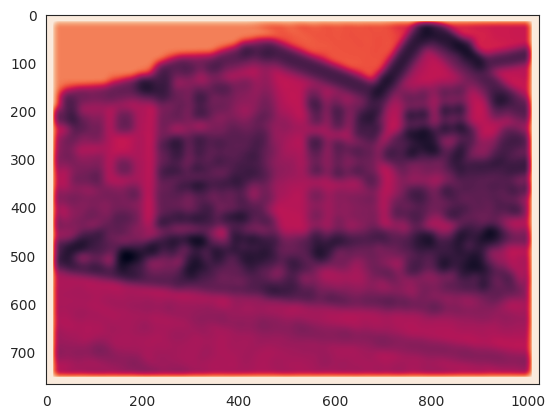

(768, 1024) -377.41799926454405 -39.539700355813196 -243.32194103226882 73.61208409011512


OSError: Can't load tokenizer for 'bert-base-uncased'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'bert-base-uncased' is the correct path to a directory containing all relevant files for a BertTokenizer tokenizer.

In [11]:
msmm = MySaliencyMapModel()

aim = pysaliency.AIM(location='../../models', cache_location=os.path.join('model_caches', 'AIM'))
smap = aim.saliency_map(mit_stimuli[10])
plt.imshow(-smap)
plt.show()
print(smap.shape, np.min(-smap), np.max(-smap), np.mean(-smap), np.std(-smap))

msap = msmm.saliency_map(mit_stimuli[10])
print(msap.shape, np.min(msap), np.max(msap), np.mean(msap), np.std(msap))
# plt.imshow(msap * 255)
plt.show()

plt.axis('off');

Evaluating Saliency Map Models
=================

Pysaliency is able to use a variety of evaluation methods to evaluate saliency models, both saliency map based models and probabilistic models. Here we demonstrate the evaluation of saliency map models

We can evaluate area under the curve with respect to a uniform nonfixation distribution:

In [ ]:
aim.AUC(short_stimuli, short_fixations, nonfixations='uniform', verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.87it/s]warning: Invalid UTF-8 byte sequences have been replaced.
    AIM_wrapper at line 5 column 18



Reading Image.
Loading Basis.
Projecting local neighbourhoods into basis space.
0        25       50       75        100
........................................
Performing Density Estimation.
0        25       50       75        100
.......................................
Transforming likelihoods into information measures.


 90%|█████████ | 9/10 [05:36<01:44, 104.87s/it]warning: Invalid UTF-8 byte sequences have been replaced.
    AIM_wrapper at line 5 column 18



Reading Image.
Loading Basis.
Projecting local neighbourhoods into basis space.
0        25       50       75        100
........................................
Performing Density Estimation.
0        25       50       75        100
.......................................
Transforming likelihoods into information measures.


100%|██████████| 10/10 [11:17<00:00, 67.72s/it] 


0.7607393835936613

By setting `nonfixations='shuffled'` the fixations from all other stimuli will be used:

In [ ]:
aim.AUC(short_stimuli, short_fixations, nonfixations='shuffled', verbose=True)

100%|██████████| 10/10 [00:00<00:00, 3062.43it/s]


0.6456897969433422

Also, you can hand over arbitrary `Fixations` instances as nonfixations:

In [ ]:
aim.AUC(short_stimuli, short_fixations, nonfixations=short_fixations, verbose=True)

100%|██████████| 10/10 [00:00<00:00, 8710.91it/s]


0.5000000000000001

Another popular saliency metric is the *fixation based KL-Divergence* as introduced by Itti. Usually it is just called *KL-Divergence* which creates confusion as there is also another completely different saliency metric called KL-Divergence (here called *image based KL-Divergence*, see below).

As AUC, fixation based KL-Divergence needs a nonfixation distribution to compare to. Again, you can use `uniform`, `shuffled` or any `Fixations` instance for this.

In [ ]:
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='uniform')
print('Fixation based KL-divergence wrt. uniform nonfixations: {:.02f}'.format(perf))

Fixation based KL-divergence wrt. uniform nonfixations: 0.44


In [ ]:
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='shuffled')
print('Fixation based KL-divergence wrt. shuffled nonfixations: {:.02f}'.format(perf))

Fixation based KL-divergence wrt. shuffled nonfixations: 0.14


In [ ]:
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations=short_fixations)
print('Fixation based KL-divergence wrt. identical nonfixations: {:.02f}'.format(perf))

Fixation based KL-divergence wrt. identical nonfixations: 0.00


The *image based KL-Divergence* can be calculated, too. Unlike all previous metrics, it needs a gold standard to compare to. Here we use a fixation map that has been blured with a Gaussian kernel of size 30px. Often a kernel size of one degree of visual angle is used.

In [ ]:
gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
perf = aim.image_based_kl_divergence(short_stimuli, gold_standard)
print("Image based KL-divergence: {} bit".format(perf / np.log(2)))

Image based KL-divergence: 1.7924752398349553 bit


The gold standard is assumed to be the real distribution, hence it has a image based KL divergence of zero:

In [ ]:
gold_standard.image_based_kl_divergence(short_stimuli, gold_standard, minimum_value=1e-20)

0.0

: 